<a href="https://colab.research.google.com/github/jdulotr/EPIJudge/blob/master/Atlassian_Tech_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initiate setting

In [3]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [0]:
%load_ext google.colab.data_table

In [120]:
%%bigquery --project stoked-cirrus-257004
SELECT *
FROM `stoked-cirrus-257004.Atlassian.jira` LIMIT 5

,time_string,unix_time,instance,product,username,event,attributes
0,"2014-12-17 14:46:42,200",1418788002200,c93da7e17688ef90fc43963b5a6c6259,jira,00fdc435d635a9f1da5743115a55f548,issuecreated,{'sendMail': '1b4364fe924a8edf298fa9fa0e36c76d...
1,"2014-12-17 14:46:41,555",1418788001555,c93da7e17688ef90fc43963b5a6c6259,jira,00fdc435d635a9f1da5743115a55f548,lexorankbalance,{'fieldId': '4537ecbd3f85c18825157673510a445d'...
2,"2014-12-17 14:46:42,240",1418788002240,c93da7e17688ef90fc43963b5a6c6259,jira,00fdc435d635a9f1da5743115a55f548,webhooks.published,{'webHookId': 'bc15cfe8aed4d319ac207c48b5c7ce7a'}
3,"2014-12-03 08:15:53,336",1417554953336,ca9c99f815b70aa9f3ab11941395116c,jira,010049167caf75cf7cb2c93f691f16c7,quicksearch,{}
4,"2014-12-24 01:59:03,277",1419346743277,ca9c99f815b70aa9f3ab11941395116c,jira,010049167caf75cf7cb2c93f691f16c7,quicksearch,{}


In [0]:
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math
import random
import scipy.stats as stats
%matplotlib inline

#1. Describe the data set in broad strokes.  Note down any data anomalies, outliers or anything you think is unusual in the data set.

In [0]:
%%bigquery --project stoked-cirrus-257004 df
SELECT
  *
FROM `stoked-cirrus-257004.Atlassian.jira`
;

In [78]:
df.isnull().sum()

time_string    0
unix_time      0
instance       0
product        0
username       0
event          0
attributes     0
is_issue       0
dtype: int64



*   Firstly, there seems like no NULL value in the data.


In [79]:
# How many users there are, and distribution of activity per user?
df.groupby('username').nunique()['time_string'].describe()

count      487.000000
mean      1036.135524
std       2339.244248
min          1.000000
25%         18.500000
50%        109.000000
75%        938.500000
max      16095.000000
Name: time_string, dtype: float64



*   Secondly on users, there are 487 users in total, and some users are more active than other users--judging from the distribution (75 percentile is only ~1000 but max is ~16k), there should be some outlier users in the data who are just too active.



In [231]:
# How many instances there are, and distribution of activity per instance?
df.groupby('instance').nunique()['time_string'].describe()

count        16.000000
mean      31534.375000
std       52678.299804
min           4.000000
25%        3380.500000
50%        7812.000000
75%       47903.750000
max      207784.000000
Name: time_string, dtype: float64

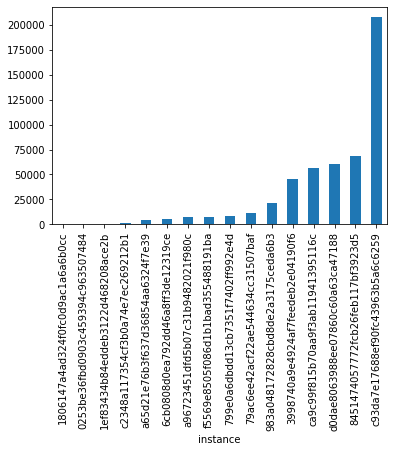

In [232]:
per_instance_act = df.groupby('instance').nunique()['time_string']
per_instance_act.sort_values().plot(kind = 'bar')



*   Also similar for instances: there are 16 instances just as described, but apparently there should be instances that are more active than others judging from the distribution stats. Given there are only 16 instances, we can also plot them out, and apparently there is one instance 'c93da7e17688ef90fc43963b5a6c6259' that has much more activity than the others.



In [233]:
# How many instances there are, and distribution of user per instance?
df.groupby('instance').nunique()['username'].describe()

count     16.000000
mean      30.750000
std       46.856519
min        1.000000
25%        3.000000
50%        7.000000
75%       31.250000
max      157.000000
Name: username, dtype: float64

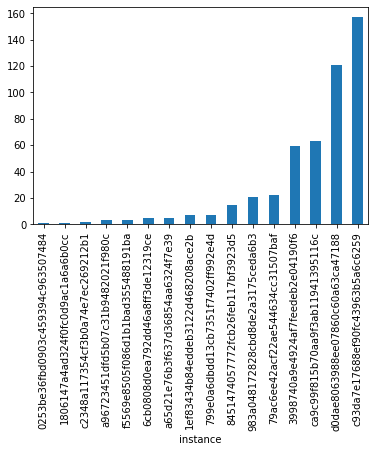

In [234]:
per_instance_user = df.groupby('instance').nunique()['username']
per_instance_user.sort_values().plot(kind = 'bar')



*   On users per instance, there are 2 instances that have more users than the rest, which potentially means they are the bigger companies among the majority of smaller companies-- I am not entirely sure what instance means, so it's just a guess.



In [235]:
# How many type of events there are, and distribution of activity per event?
df.groupby('event').nunique()['time_string'].describe()

count      552.000000
mean      1063.757246
std       5456.392887
min          1.000000
25%          3.000000
50%         11.000000
75%         80.000000
max      64389.000000
Name: time_string, dtype: float64



*   Here we find that there are certain type of events that happen much more frequently than the rest--it could be an outlier type of event.



In [236]:
# How many days there are, and distribution of type of event per day? 
# I didn't look into distribution of user per day because question 2) asks.
df['date'] = df['time_string'].str.split().str[0]
df.groupby('date').nunique()['event'].describe()

count     31.000000
mean     174.806452
std       61.261418
min       55.000000
25%      132.000000
50%      190.000000
75%      223.000000
max      276.000000
Name: event, dtype: float64



*   Lastly we can see num of event types per day, the min is much smaller than 25 percentile, so there could be anormalies on one or more day. 



#2. Plot a trend of the number of daily active users (DAU) for this data set. What jumps out at you from this trend?

In [0]:
%%bigquery --project stoked-cirrus-257004 dau_trend
SELECT
  FORMAT_TIMESTAMP('%F', TIMESTAMP_MILLIS(unix_time)) AS date, 
  COUNT(DISTINCT username) AS users
FROM `stoked-cirrus-257004.Atlassian.jira`
GROUP BY 1
ORDER BY 1;

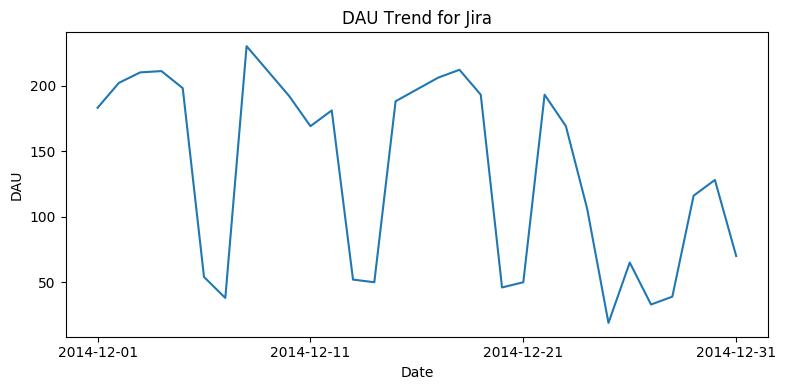

In [238]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8, 4), dpi = 100)
ax.plot(dau_trend['date'], dau_trend['users'])
ax.set_xticks(dau_trend['date'][::10])
ax.set_xticklabels(dau_trend['date'][::10])
ax.set_xlabel('Date')
ax.set_ylabel('DAU')
ax.set_title("DAU Trend for Jira")
fig.tight_layout(w_pad=10)

From above chart, there seems like there is another data anomalies problem, basically for the dates post December 21st the DAU trend goes down quite a bit. 

I think this could be because of the holiday seasonality effect--since Jira is a work related product, near Christmas holiday time, users would not go to work and thus won't use the product as frequently as previous times.  

To test whether this hypothesis is true, I would recommend looking into historical data, and check if in the past there were similar trends also happening around December. If there is, then it's seasonality. 

#3.  What is the average usage of "dashboardview" per user per day, when they are active in the product? What is the proportion of users who triggered "dashboardview" during the month of December 2014? Quantify the margin of error of your estimate.

In [239]:
avg_active = df.query('(event == "dashboardview")').groupby('username').nunique().mean()['time_string']
total = df.nunique()['username']
dashboard = df.query('(event == "dashboardview")').nunique()['username']

# Get 95% confidence z-score, as sample > 30.
z_critical = stats.norm.ppf(q = 0.975)
# Point estimate of proportion
p = dashboard / total
# Sample size
n = total
# Get MEquery('(event == "dashboardview")')
margin_of_error = z_critical * math.sqrt((p*(1-p))/n)
# Calculate CI
confidence_interval = (p - margin_of_error,
                       p + margin_of_error) 

print('Average usage of dashboardview is {:.0f} per user per day.'.format(avg_active))
print('Proportion of users who triggered dashboardview in December 2014 is {:.2%}.'.format(dashboard/total))
print('With margin of error {:.2f}, confidence interval of the trigger rate is \
({:.2%} , {:.2%}).'.format(margin_of_error, confidence_interval[0], confidence_interval[1]))


Average usage of dashboardview is 22 per user per day.
Proportion of users who triggered dashboardview in December 2014 is 64.07%.
With margin of error 0.04, confidence interval of the trigger rate is (59.80% , 68.33%).


Average usage of dashboardview is 22 per user per day.
Proportion of users who triggered dashboardview in December 2014 is 64.07%.
With margin of error 0.04, confidence interval of the trigger rate is (59.80% , 68.33%).

#4.  Compare users "778251ffec35de6bbbb089198b9ac516" and "7e7a085a9f6f55253b2aa15dbcb702a8" from the instance "c93da7e17688ef90fc43963b5a6c6259"; would you conclude their average number of events per day to be different? Justify your answer.

In [0]:
%%bigquery --project stoked-cirrus-257004 user_test
SELECT 
  username,  
  FORMAT_TIMESTAMP('%F', TIMESTAMP_MILLIS(unix_time)) AS date, 
  COUNT(DISTINCT event) AS cnt_event
FROM `stoked-cirrus-257004.Atlassian.jira`
WHERE instance = "c93da7e17688ef90fc43963b5a6c6259"
  AND username IN ("778251ffec35de6bbbb089198b9ac516", "7e7a085a9f6f55253b2aa15dbcb702a8")
GROUP BY 1, 2;

In [241]:
user_test.groupby("username")['cnt_event'].describe()

,count,mean,std,min,25%,50%,75%,max
username,,,,,,,,
778251ffec35de6bbbb089198b9ac516,23.0,31.217391,15.988509,1.0,32.5,36.0,41.0,51.0
7e7a085a9f6f55253b2aa15dbcb702a8,29.0,22.586207,21.056925,1.0,2.0,21.0,36.0,94.0


For 31 data points in December, we can have hypothesis:

H0 : the two users are the same on average events per day;

H1 : the two users are not the same on average events per day; 

Notice that the sample size is not equal and also quite small, so it's an unpaired t-test. Let's set the sigficance level to 0.05.

In [242]:
user_a = user_test[(user_test['username'] == '778251ffec35de6bbbb089198b9ac516')]
user_a.reset_index(inplace= True)

user_b = user_test[(user_test['username'] == '7e7a085a9f6f55253b2aa15dbcb702a8')]
user_b.reset_index(inplace= True)

stats.levene(user_a['cnt_event'], user_b['cnt_event'])

LeveneResult(statistic=2.6425658193912076, pvalue=0.1103228349280614)

Text(0.5, 1.0, 'Count event prob plot')

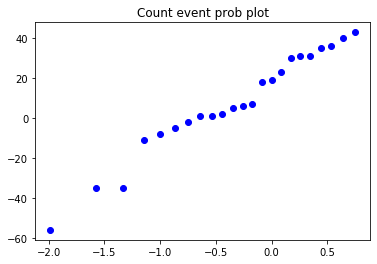

In [213]:
diff = user_a['cnt_event'] - user_b['cnt_event']
stats.probplot(diff, plot= plt)
plt.title('Count event prob plot') 

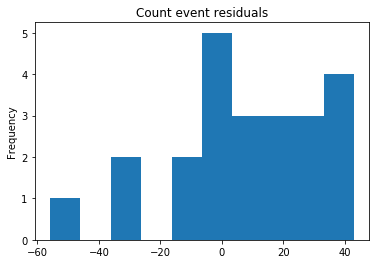

In [214]:
diff.plot(kind= "hist", title= "Count event residuals")

With above, it looks like a t-test result could be trusted.

*   Levene test is not significant meaning there is homogeneity of variances
*   The data maintains roughly normality judging from the 2 plots.



In [215]:
stats.ttest_ind(user_a['cnt_event'], user_b['cnt_event'])

Ttest_indResult(statistic=1.6274627056825892, pvalue=0.10992509525670535)

However, with the p-value of this t-test > significance level (0.11 > 0.05), we can’t conclude that they are significantly different. 

#5.  Our users tend to use multiple features together when they use our products. Cluster events that tend to appear together into groups, and explain how and why you have clustered events in such a way.

In [0]:
%%bigquery --project stoked-cirrus-257004 event_gap
SELECT
	username, 
	time_string,
	event,
	(unix_time - LAG(unix_time, 1, 0) OVER (PARTITION BY username ORDER BY unix_time)) / 1000 AS gap_second
FROM `stoked-cirrus-257004.Atlassian.jira`
;

In [191]:
event_gap.head()

,username,time_string,event,gap_second
0,00fdc435d635a9f1da5743115a55f548,"2014-12-17 14:46:41,555",lexorankbalance,1.418788e+09
1,00fdc435d635a9f1da5743115a55f548,"2014-12-17 14:46:42,200",issuecreated,6.450000e-01
2,00fdc435d635a9f1da5743115a55f548,"2014-12-17 14:46:42,240",webhooks.published,4.000000e-02
3,010049167caf75cf7cb2c93f691f16c7,"2014-12-02 01:03:46,614",devstatus.summary.shown.assignee,1.417443e+09
4,010049167caf75cf7cb2c93f691f16c7,"2014-12-02 01:07:01,659",devstatus.summary.shown.assignee,1.950450e+02


In [209]:
# check what should be the threshold for gap.  
hist = np.histogram(event_gap['gap_second'], \
                    bins=[0, 1, 2, 5, 30, 60, 300, 600, 1800, 3600, 3600*24, 7*3600*24],\
                    density=True)[0]
np.set_printoptions(precision=4, suppress = True)
print(hist)

[0.6298 0.0441 0.0422 0.0039 0.0007 0.0002 0.     0.     0.     0.
 0.    ]


Firstly we do an exploratory data analysis (EDA) and try to set a reasonable threshold for time gap between two events for a user for further clustering. The time gaps are calculated in SQL and then imported to dataframe.  Then from the returns of histogram of time gaps, it is clear that within 30s, majority of events happened. Therefore, we choose 30s as the time gap threshold to cluster events that happen together. 


In [243]:
#Check the event gap time is larger than 30s and group the events into rough categories
event_gap['followup'] = False
event_gap.loc[(event_gap['gap_second'] <= 30), 'followup'] = True
event_gap['event_rough'] = [x.split('.')[0] for x in event_gap['event'].values]

events = event_gap.event_rough.unique()
len(events)

135

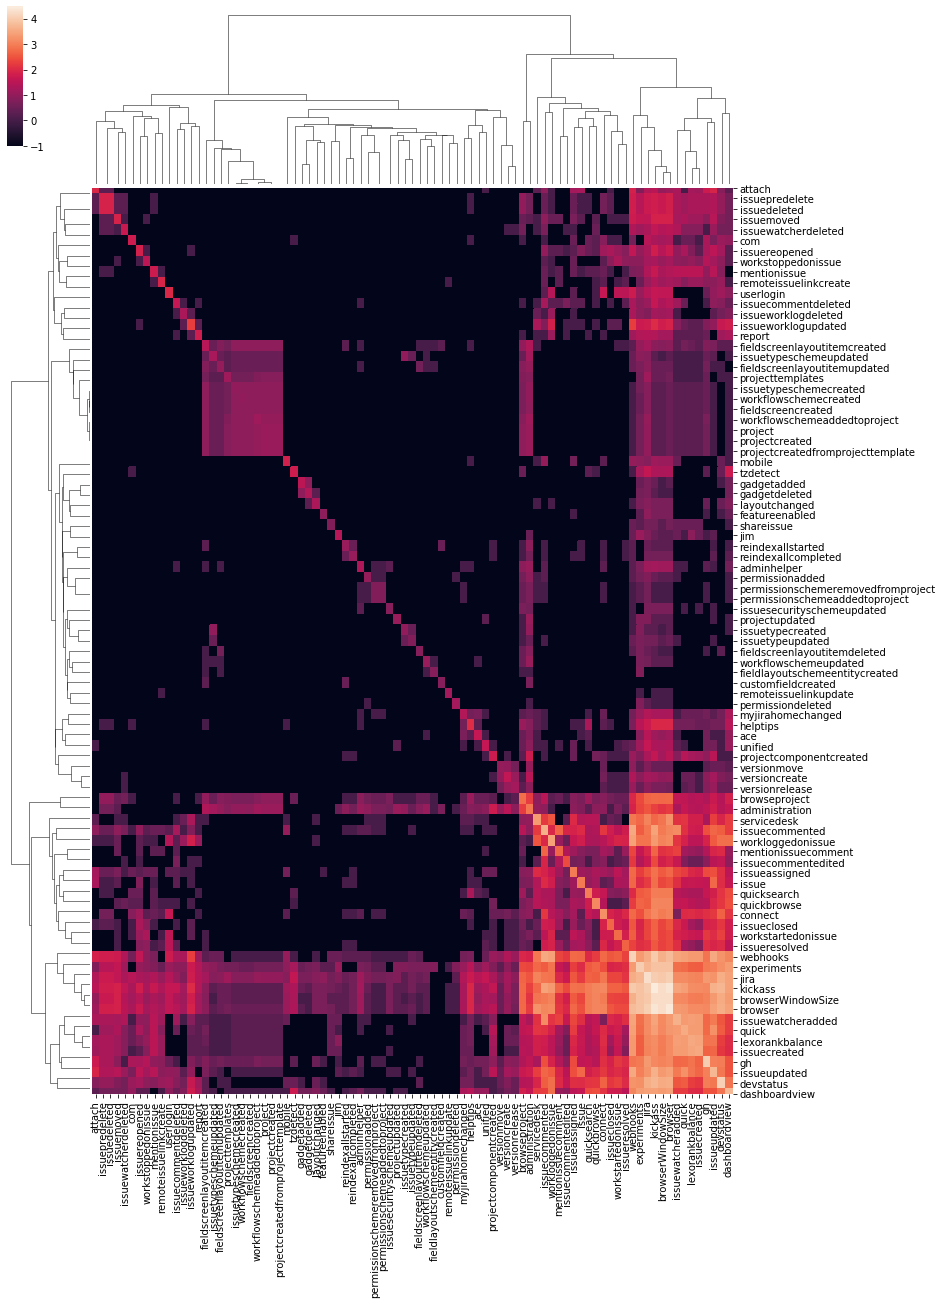

In [226]:
#Cluster events by user and event gap time
gn = -1
gns = []
old_user = ''
for ir, (_, row) in enumerate(event_gap.iterrows()):
    #if ir % 10000 == 0:
    #    continue
    us = row['username']
    val = row['followup']
    if (us != old_user) or (val == False):
        gn += 1
    gns.append(gn)
    old_user = us
event_gap['group_n'] = gns

# Calculate co-occurrence of events
corr = pd.DataFrame(data=np.zeros((len(events), len(events))), index=events, columns=events)
for gn, group in event_gap.groupby('group_n'):
    #if gn % 1000 == 0:
    #    continue
    events_un = group['event_rough'].unique()
    for ev1 in events_un:
        for ev2 in events_un:
            corr.loc[ev1, ev2] += 1
    
# Plot events correlation in chart
ind = corr.values[np.arange(len(corr)), np.arange(len(corr))] > 5
sns.clustermap(np.log10(0.1+corr.loc[ind, ind]), xticklabels=True, yticklabels=True, figsize = (13,20))


Secondly we calculate the co-occurence of different events within the same cluster, and based on the frequency of co-occurrence,  we have the above chart and it shows 5 clusters of events pairs (the heated areas)

2 large clusters that showing strong correlations:


* From dashboardview to browseproject within themselves;
* From attach to report and dashboard to issueresolved;


3 smaller clusters that showing some correlations:


*   From fieldscreenlayoutitemcreated to projectcreatedfromprojecttemplate and dashboard to issueresolved;
*   From report to projectcreatedfromprojecttemplate within themselves
*   Between issuepredelete and issuedeleted






#6.  Is there anything else you find interesting about the usage pattern you'd like to tell us?

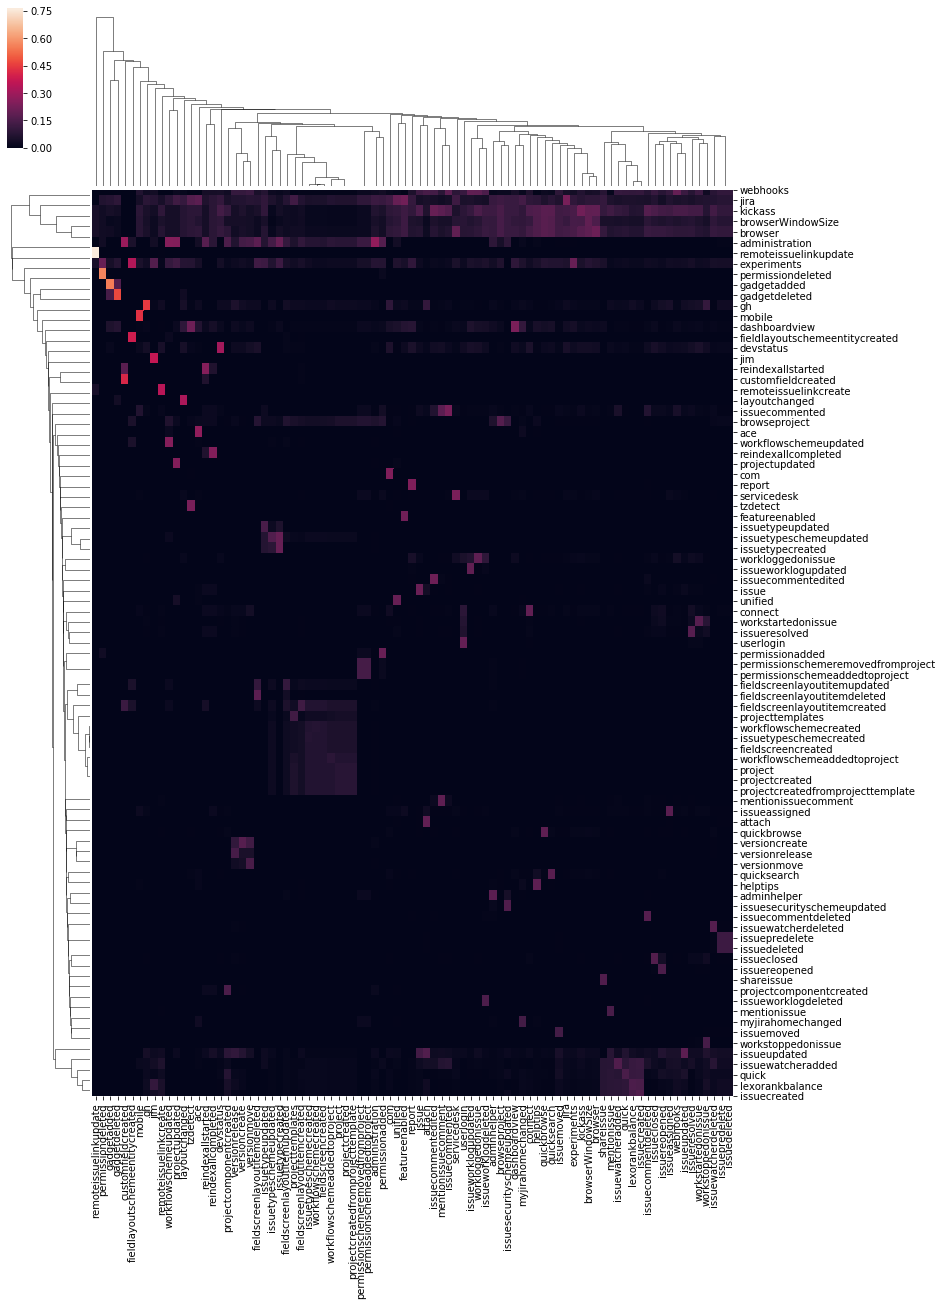

In [245]:
# Plot events probability of showing with a given event in a chart
corr2 = corr.copy()
corr2 = corr2 / corr2.sum()

sns.clustermap(corr2.loc[ind, ind], xticklabels=True, yticklabels=True, figsize = (13,20))

Follow up on question 5, for a given event, we calculate the probability of another event happening as below chart.  Findings:
* There are two events that are only used alone (heated red area): mobile, gh. It means if the users are using these features, then they are used alone and not together with the other features;
* If a user is using a feature other than gh or mobile, then they are most likely to use jira, kickass, browerwindowsize and browser at the same time (the pink heated area).


In [0]:
%%bigquery --project stoked-cirrus-257004 issues
SELECT
  time_string, 
  unix_time, 
  instance, 
  product, 
  username, 
  event, 
  FORMAT_TIMESTAMP('%F', TIMESTAMP_MILLIS(unix_time)) AS date,
  CONCAT(REPLACE(JSON_EXTRACT(attributes, '$.id'),'"',''), REPLACE(JSON_EXTRACT(attributes, "$['user.name']"),'"','')) AS issue,
  REPLACE(JSON_EXTRACT(attributes, "$['user.name']"),'"','') AS user_name
FROM `stoked-cirrus-257004.Atlassian.jira`
WHERE event IN ('issuecreated','issueresolved')
;

In [0]:
issues = pd.DataFrame(issues)

In [104]:
results = {
    'n_created':  0,
    'n_resolved': 0,
    'n_created_and_resolved': 0,
    'unix_times': [],
    'weirdo': {},
}
for issue, group in issues.groupby('issue'):
    if 'issuecreated' in group['event'].values:
        results['n_created'] += 1
    if 'issueresolved' in group['event'].values:
        results['n_resolved'] += 1
    if 'issuecreated' in group['event'].values and 'issueresolved' in group['event'].values:
        results['n_created_and_resolved'] += 1
        ind1 = group.index[group['event'] == 'issuecreated'][0]
        ind2 = group.index[group['event'] == 'issueresolved'][0]
        results['unix_times'].append((group.loc[ind2, 'unix_time'] - group.loc[ind1, 'unix_time']) / 1000 / 3600)
        if results['unix_times'][-1] < 0:
            results['weirdo'][issue] = group
results


{'n_created': 4075,
 'n_created_and_resolved': 96,
 'n_resolved': 605,
 'unix_times': [327.21182500000003,
  26.30600222222222,
  69.38501833333333,
  0.08339527777777778,
  1.441611388888889,
  407.16673972222225,
  94.12527444444444,
  99.43520972222223,
  48.93487555555556,
  18.088717222222222,
  46.75445361111111,
  27.531155277777778,
  2.700736111111111,
  22.987266944444443,
  17.68869388888889,
  1.1813277777777778,
  2.186133888888889,
  0.017498333333333334,
  47.63972666666667,
  0.4391741666666667,
  27.88928111111111,
  29.15024638888889,
  197.21717694444445,
  1.9572025,
  98.50234,
  159.77142916666668,
  0.251115,
  73.96019,
  27.540176944444447,
  430.29958194444447,
  27.340985833333335,
  0.83296,
  22.93171611111111,
  6.1306561111111115,
  0.04621666666666666,
  1.0092775,
  66.68923444444445,
  4.972677222222222,
  97.67780944444445,
  0.0136025,
  51.94298222222222,
  6.937485,
  22.50155666666667,
  144.4716061111111,
  1.400663611111111,
  119.47641055555555

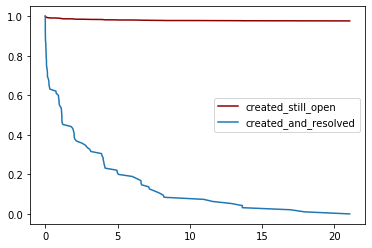

In [106]:
# Plot out how many % of issues created and resolved are still left open within X days;
# Plot out how many % of issues created are still left open within X days;
times = results['unix_times']
x = np.sort(times)
y = 1.0 - np.linspace(0, 1, len(x))
y2 = 1.0 - np.linspace(0, 1.0 * results['n_created_and_resolved'] / results['n_created'], len(x))
plt.plot(x / 24., y2, label = 'created_still_open', color='darkred')
plt.plot(x / 24., y, label='created_and_resolved')
plt.legend()


Also digging a bit into the attribute field, there is a field Id that can be linked across all events. So we try to dig into these questions:

1 How many issues are created and resolved?

2 How long does it take for an issue to be resolved?

Using username and Id in attribute combination as unique key, we have from below code a chart and it shows:
During December 2014, there are 4075 issues created, and 605 issues resolved (including issues created from before). Among these created issues, only 96 were resolved (2.4% of the total issues created this month);
The 2.4% of issues created and resolved in this month are resolved quite fast, and more than 80% of them are resolved within 5 days;
The majority of issues created in this month were left open for more than 20 days not resolved.
